In [44]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy.stats as stats
from scipy import signal

In [45]:
curve = pickle.load(open("../data/trajs/curve.pkl",'rb'))
start = (curve[0][0], curve[1][0])
goal = (curve[0][-1], curve[1][-1])

In [46]:
class DMP:
    def __init__(self, num_bfs = 5):
        self.num_bfs = num_bfs     # num of basis functions
        self.K = 25*25/4     # Spring coefficient
        self.B = 25          # damper coefficient
        self.C = np.linspace(0, 1, self.num_bfs)    # num of basis fn centers
        self.H = 0.65*(1/(self.num_bfs - 1))**2      # bf widths
        
        self.weights = [0, 0, 0, 0, 0]
        self.start = self.goal = self.T = 0
        self.q = self.qd = self.qdd = 0
        
    def set_task_params(self, start, goal, T, dt):
        self.dt = dt
        self.start = start
        self.goal = goal
        self.T = T
        self.q = self.start
        self.qd = self.qdd = 0
        
    def fwd_simulate(self, horizon, weights):
        t = 0
        pos = []
        for i in range(horizon):
            t += self.dt
            if t <= self.T:
                phi = [np.exp(-((t/self.T - c)**2)/2/self.H) for c in self.C]
                phi /= np.sum(phi)
#                 print(phi)
                f = np.dot(phi, weights)
            else:
                f = 0
            self.qdd = (self.K*(self.goal-self.q)/(self.T**2)) - self.B*self.qd/self.T + (self.goal-self.start)*f/(self.T**2)
            self.qd += self.qdd * self.dt
            self.q += self.qd * self.dt
            pos.append(self.q)
        return np.array(pos)

Start: 0.0, Goal: 0.03524106751143952


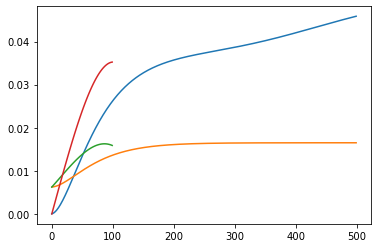

-0.06551319542933311


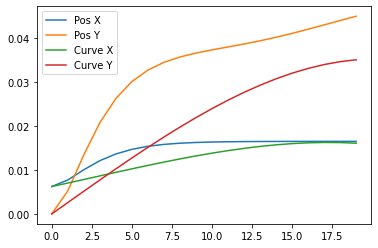

In [47]:
dmp = DMP()
dmp.set_task_params(start[0], goal[0], 5, 0.01)
pos_x = dmp.fwd_simulate(500, 10*np.array([1,1,1,1,1]))
dmp.set_task_params(start[1], goal[1], 5, 0.01)
print(f"Start: {start[1]}, Goal: {goal[1]}")
pos_y = dmp.fwd_simulate(500, 10*np.array([0, 1, 1, 4, 7]))

plt.plot(pos_y)
plt.plot(pos_x)
plt.plot(curve[0])
plt.plot(curve[1])
plt.show()

# pos_x2 =  signal.resample(pos_x, 20)
# pos_y2 =  signal.resample(pos_y, 20)
# curve_x = signal.resample(curve[0], 20)
# curve_y = signal.resample(curve[1], 20)
pos_x2 = pos_x[::len(pos_x)//20]
pos_y2 = pos_y[::len(pos_y)//20]
curve_x = curve[0][::len(curve[0])//20]
curve_y = curve[1][::len(curve[1])//20]

reward = -(np.linalg.norm(pos_x2 - curve_x) + np.linalg.norm(pos_y2 - curve_y))
print(reward)
plt.plot(pos_x2, label="Pos X")
plt.plot(pos_y2, label="Pos Y")
plt.plot(curve_x, label="Curve X")
plt.plot(curve_y, label="Curve Y")
plt.legend()

In [ ]:
dmp = DMP()
for i in range(100):
    weights = np.random.normal([0,0,0,0,0,-0.1,-0.1, 0, 0, 0.1], 0.35, 10)
    dmp.set_task_params(0, 0.015, 5, 0.01)
    pos_x = dmp.fwd_simulate(500, 200*np.array(weights[:5]))
    dmp.set_task_params(0, 0.035, 5, 0.01)
    print(f"Start: {start[1]}, Goal: {goal[1]}, Weight: {weights}")
    pos_y = dmp.fwd_simulate(500, 200*np.array(weights[5:]))
    
    pos_x2 = pos_x[::len(pos_x)//20]
    pos_y2 = pos_y[::len(pos_y)//20]
    skill_traj = np.vstack([pos_x2, pos_y2]).T
    skill_traj[:, 0] = 100*np.clip(skill_traj[:, 0], -0.005, 0.025)
    skill_traj[:, 1] = 100*np.clip(skill_traj[:, 1], -0.005, 0.05)
    print(skill_traj.shape)
    
    plt.plot(skill_traj[:,0], skill_traj[:,1])
    _ = plt.plot(pos_x, pos_y)
    plt.show()

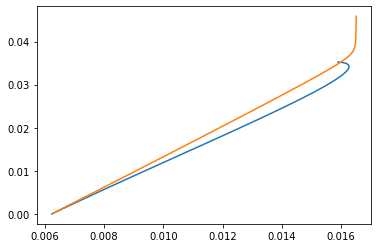

In [48]:
plt.plot(curve[0], curve[1])
_ = plt.plot(pos_x, pos_y)

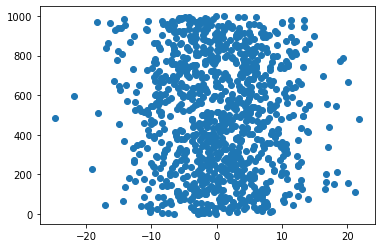

In [49]:
# Test Gaussian Normalization
x = np.random.normal(0, 0.35, 1000)
y = np.arange(1000)
x = x*20
plt.scatter(x,y)

In [62]:
class Env():
    def __init__(self, start, goal, reference, n_bfs = 5):
        curve_x = reference[0][::len(reference[0])//20]
        curve_y = reference[1][::len(reference[1])//20]
        self.reference = [curve_x, curve_y]
        self.start = start
        self.goal = goal
        self.n_bfs = n_bfs
        self.dmp_x = DMP(n_bfs)
        self.dmp_x.set_task_params(start[0], goal[0], 5, 0.01)
        self.dmp_y = DMP(n_bfs)
        self.dmp_y.set_task_params(start[1], goal[1], 5, 0.01)
        self.return_vars = {"observation": None, "reward": None, "done": None, "info": {"is_solved": False}}
        self.a = 0
        
    def step(self, weights):
        pos_x = self.dmp_x.fwd_simulate(500, 40*np.array(weights[:self.n_bfs]))
        pos_y = self.dmp_y.fwd_simulate(500, 40*np.array(weights[self.n_bfs:]))
        
        pos_x2 = pos_x[::len(pos_x)//20]
        pos_y2 = pos_y[::len(pos_y)//20]
        
        reward = -100 * (np.linalg.norm(pos_x2 - self.reference[0]) + np.linalg.norm(pos_y2 - self.reference[1]))

        print(reward)
        plt.plot(pos_x2, pos_y2, label="Pos X")
        plt.plot(self.reference[0], self.reference[1], label="Curve X")
        plt.legend()
        plt.show()

        done = False
        if abs(reward) < 2:
            plt.plot(pos_x2, pos_y2, label="Pos X")
            plt.plot(self.reference[0], self.reference[1], label="Curve X")
            plt.legend()
            plt.show()
            reward = 10
            done = True
        self.a += 1
        return None, reward, done, {"is_solved": done}
    
    def reset(self):
        self.dmp_x.set_task_params(self.start[0], self.goal[0], 5, 0.01)
        self.dmp_y.set_task_params(self.start[1], self.goal[1], 5, 0.01)
        return
    def context(self):
        # Some random function of no significance. But don't remove it!! Needed for REPS
        return None
    def store_trajectory(self):
        # Another random function of no significance. But don't remove it!! Needed for REPS
        return 

REPS attempt 1 of 10: 
policy_params_mean_init_this_attempt:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
policy_params_var_init_this_attempt:
[[0.35 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.35 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.35 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.35 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.35 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.35 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.35 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.35 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.35 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.35]]
-6.992627936932847


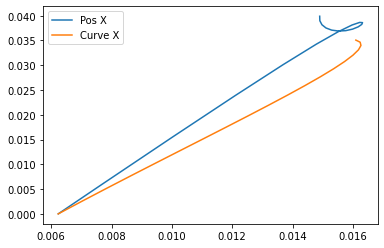

-5.173798110307551


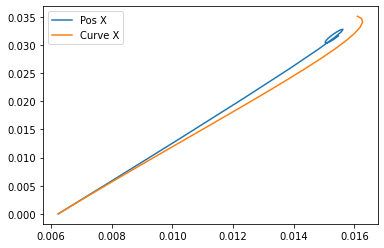

-4.792351258164336


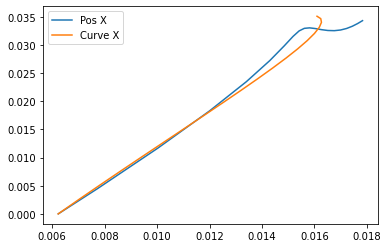

-5.887777604833596


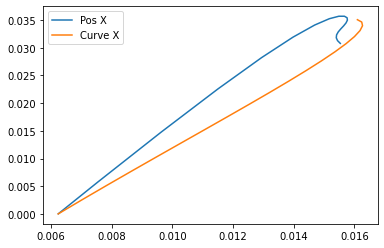

-4.454730007129499


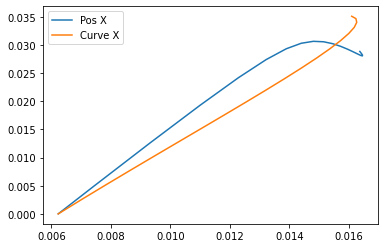

-5.405126393147206


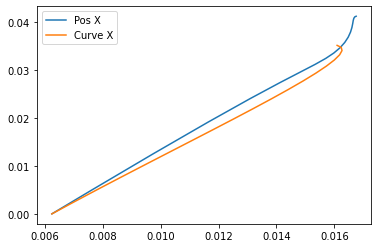

-5.688513132670918


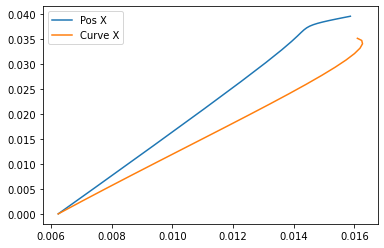

-4.771428175436287


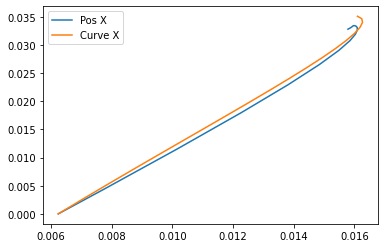

-6.118865350547291


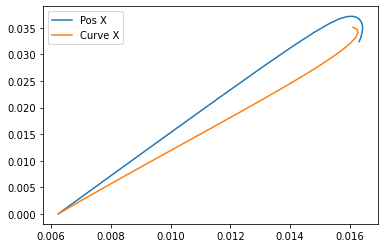

-5.257695482560052


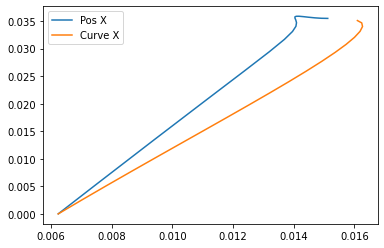

-4.670785773077308


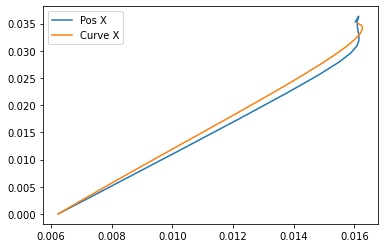

-5.044547083262009


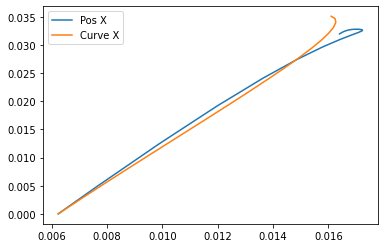

-4.966622949171798


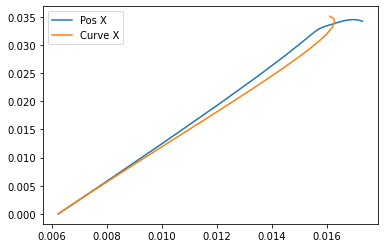

-4.790408156261352


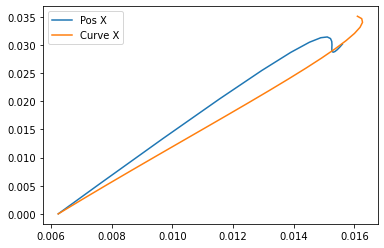

-7.060123554911449


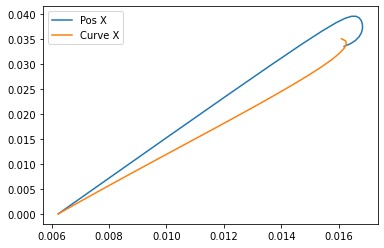

-5.497317576961698


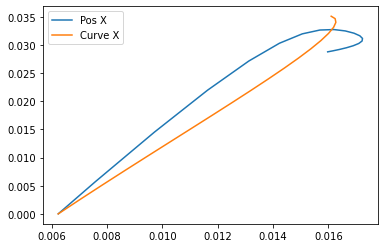

-6.552248614304276


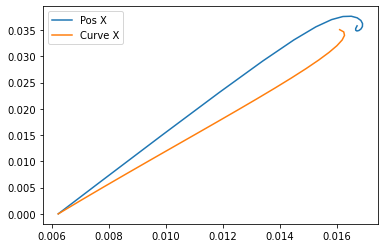

-4.497025877610246


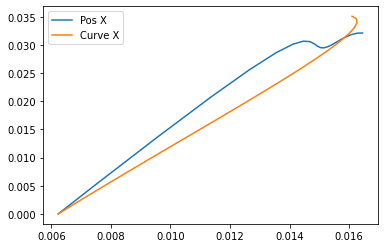

-7.8978059447812905


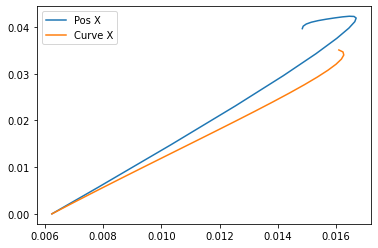

-4.368676310507222


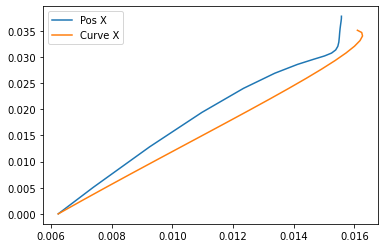

-5.284575565581201


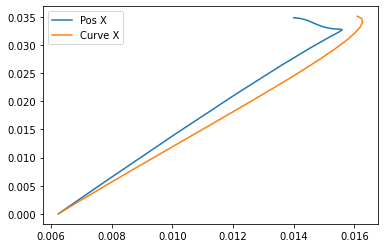

-5.279194286332001


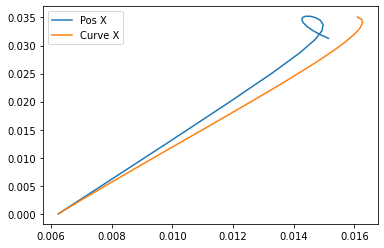

-7.423172681742293


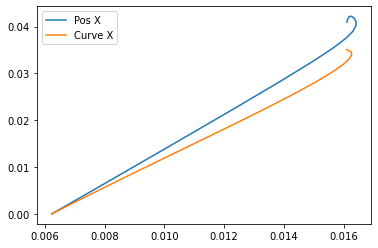

-3.8868958408300984


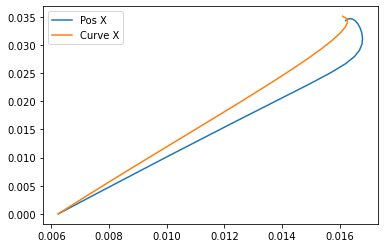

-4.683318903063673


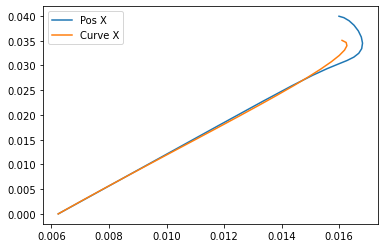

-5.613703414440486


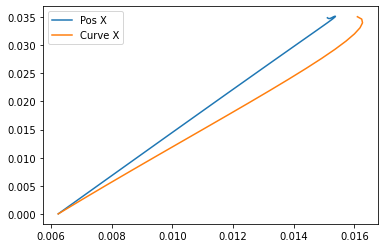

-6.988549985973316


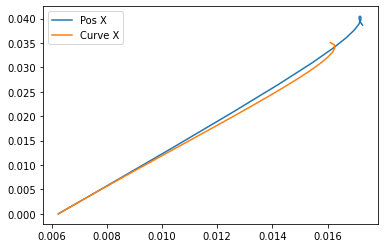

-5.366081645262803


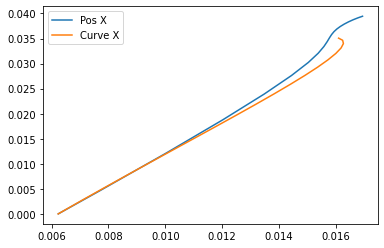

-6.7326184111961895


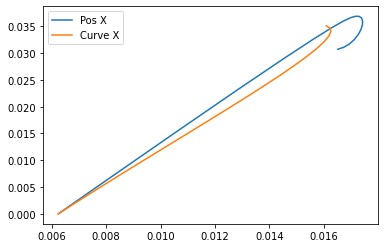

-5.621313294924783


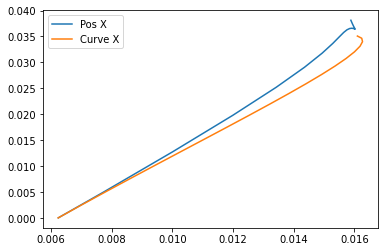

-4.778771352121691


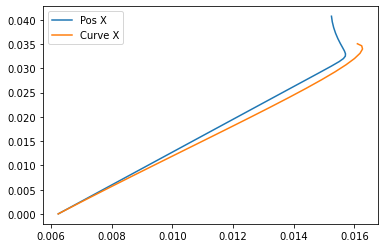

-5.054673550497601


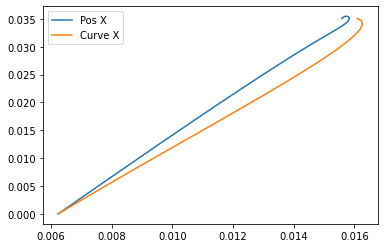

-5.745094195006968


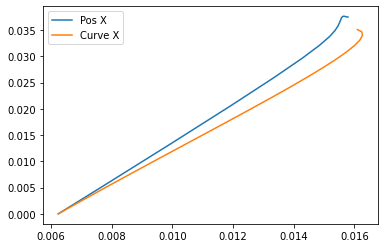

-5.4814110936413485


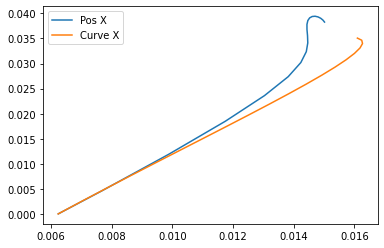

-5.8211823755799985


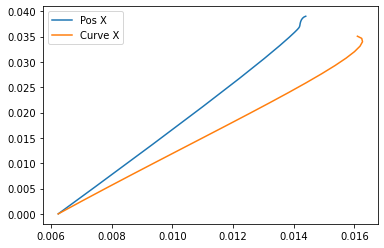

-6.37781690306598


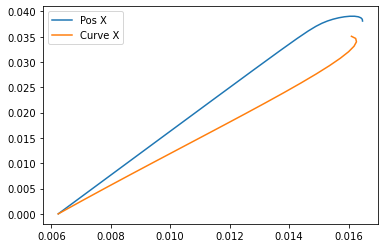

-5.5972873653025195


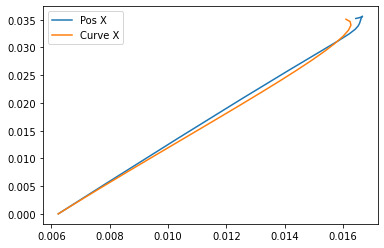

-6.179520574455232


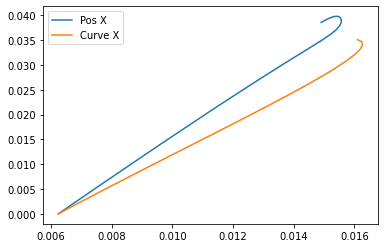

-5.680351793238851


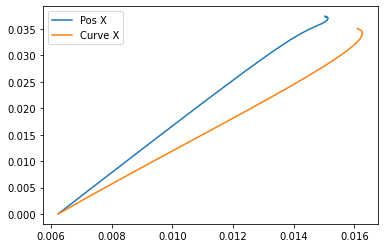

-5.596872175684556


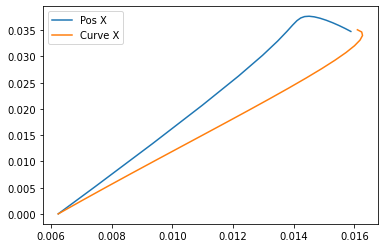

-4.480871024338538


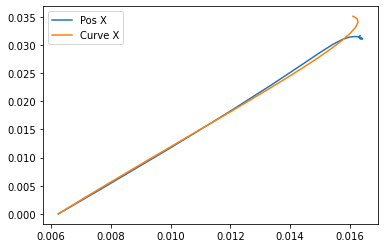

-6.324193484088676


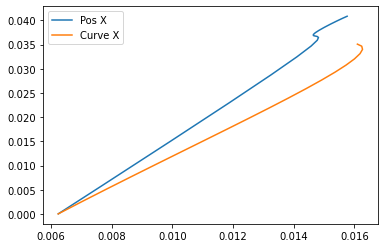

-4.856102238950315


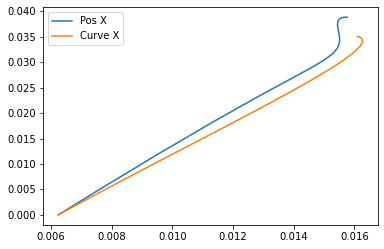

-6.2777290674888615


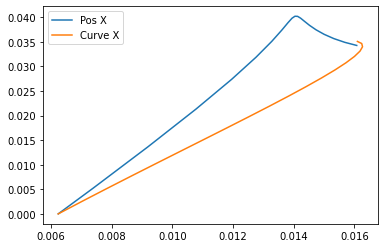

-5.566821662196976


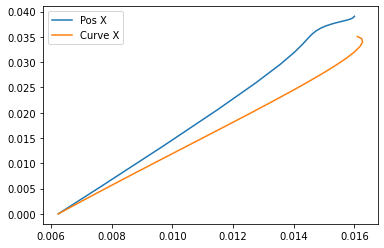

-5.345553338121893


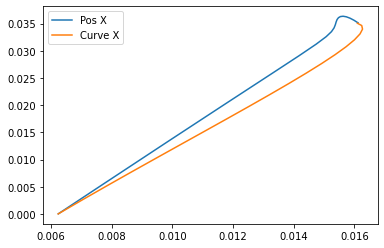

-6.740797445693331


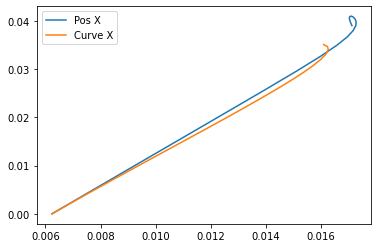

-7.793251708765962


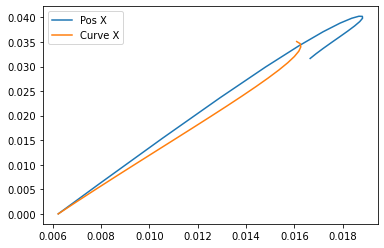

-3.898917708079648


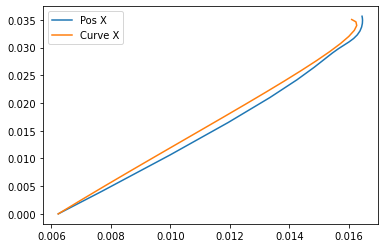

-4.692783646990783


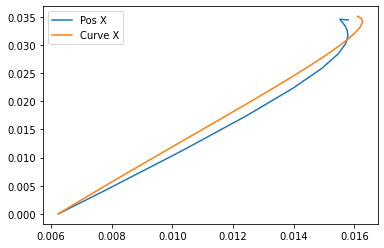

-4.428238878432833


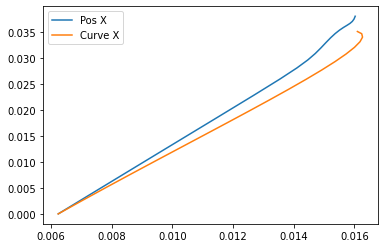

-5.657270149688678


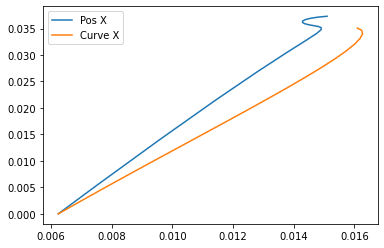

-5.180896724470367


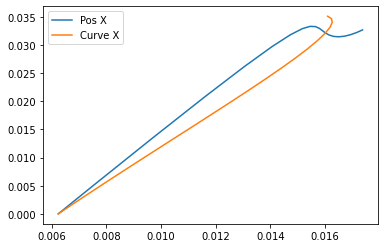

-3.877864837458412


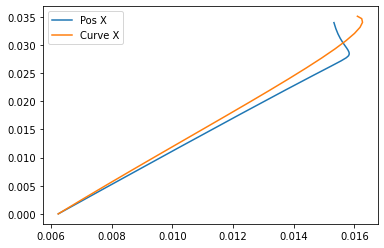

-5.178961863240181


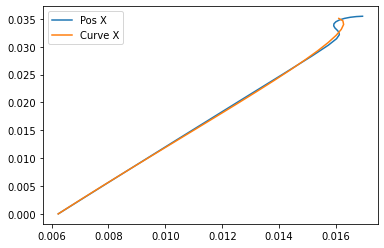

-6.4978907855411965


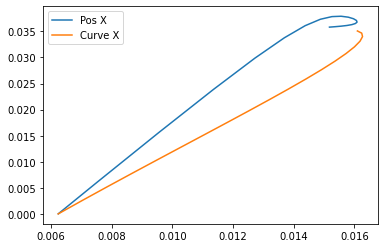

-5.530527758213095


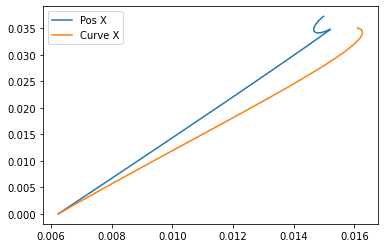

-5.758570291659554


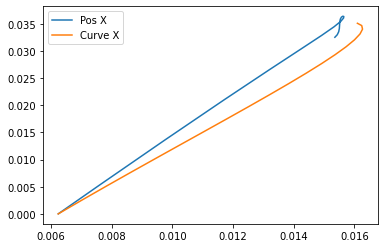

-7.973630059497834


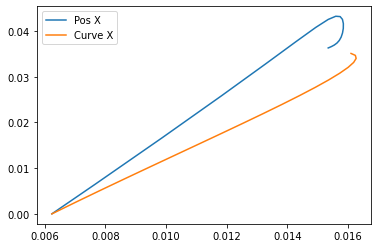

-5.522595423728072


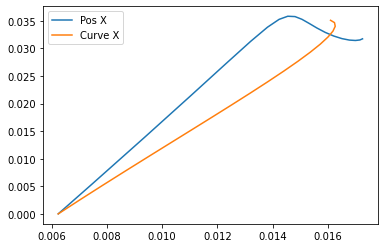

-5.456606415283514


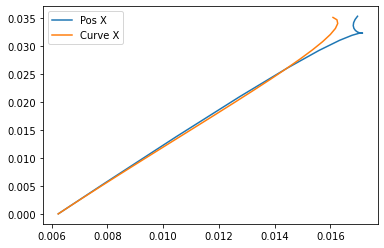

-2.94382962014485


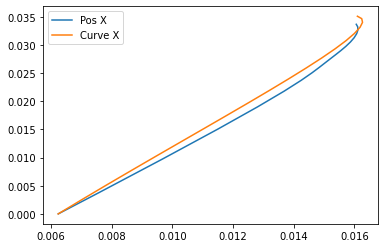

-3.6684969187818246


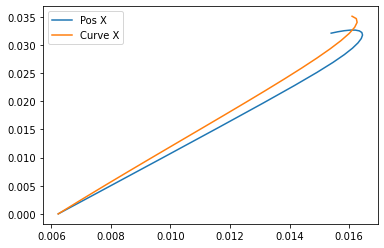

-6.1087872955532685


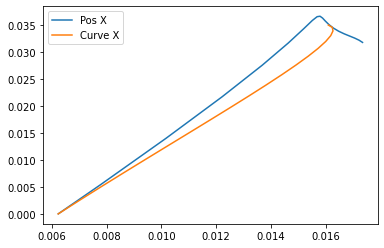

-5.57811541398677


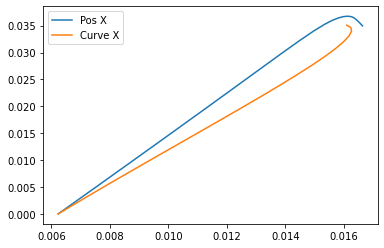

-5.73332329721913


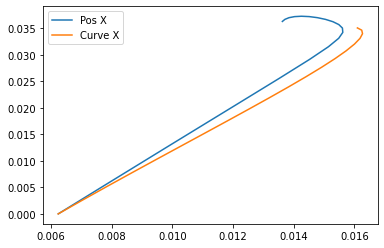

-4.778273909356663


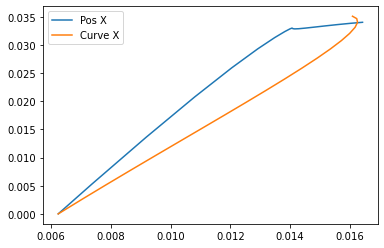

-6.4797154799807855


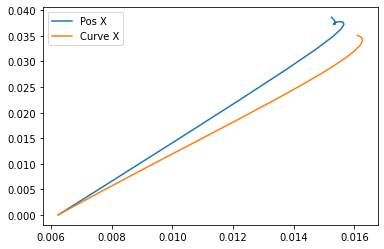

-6.1272961305869424


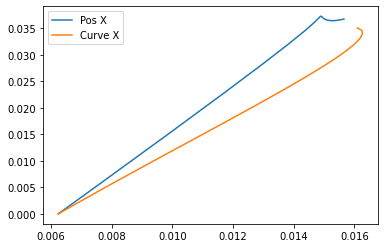

-5.893277510063438


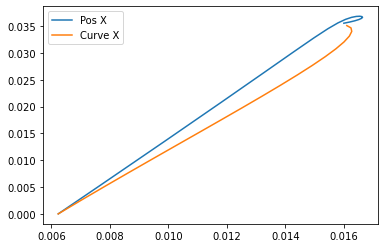

-5.252411689932007


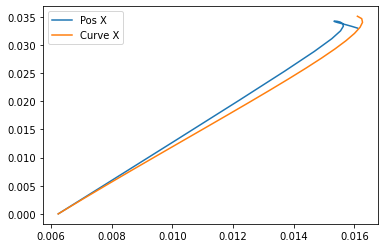

-6.060687745704331


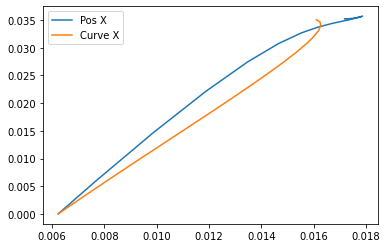

-5.217381163696904


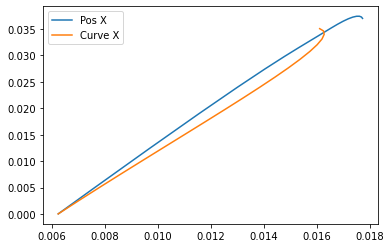

-5.066984675523154


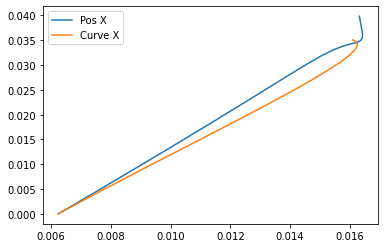

-5.881881306088492


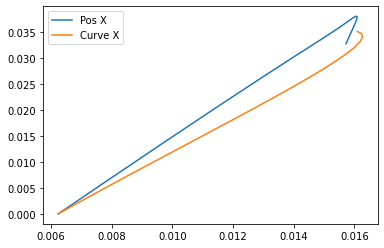

-4.6324465841336995


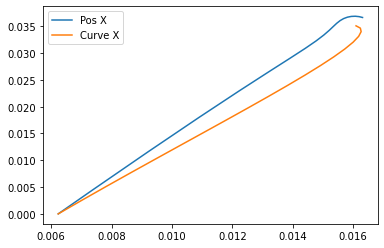

-3.737091894453834


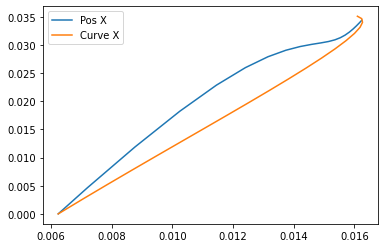

-5.081287408591752


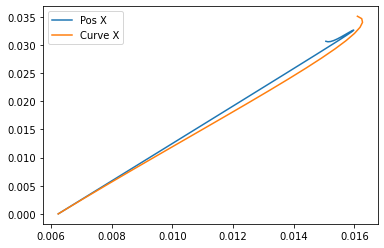

-4.160840968152167


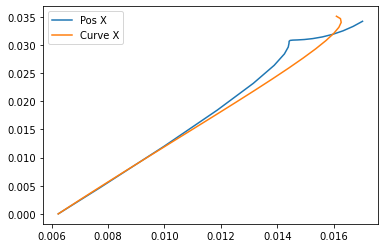

-4.392607456238164


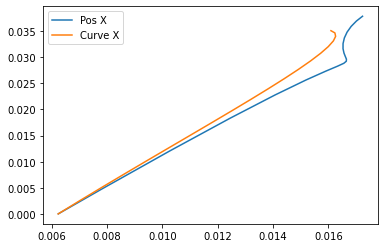

-6.2411886181405345


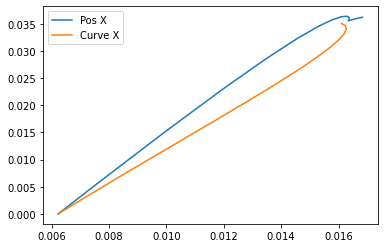

-4.049253825996495


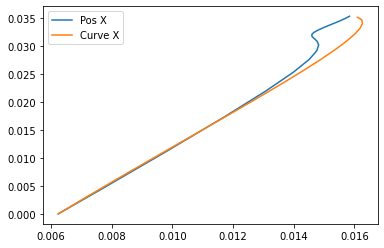

-5.463010292112062


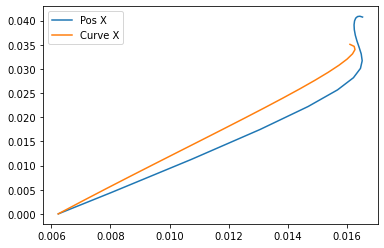

-5.871086122461763


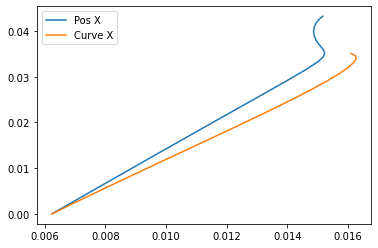

-5.783870524017742


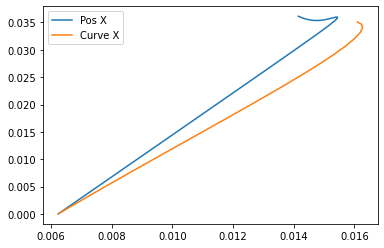

-5.45164615785724


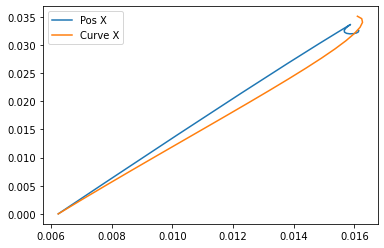

-5.716005856700974


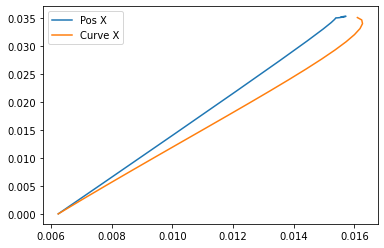

-4.30811042139006


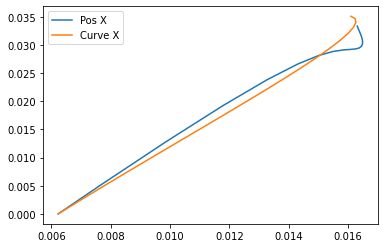

-5.54934784479604


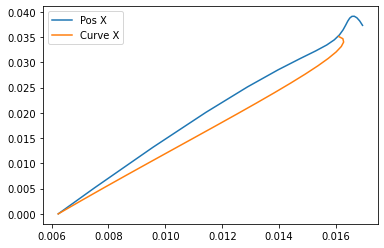

-5.231696708765403


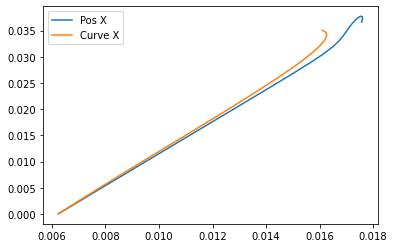

-4.9547086510582306


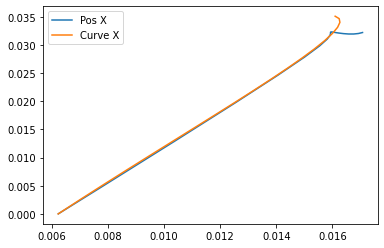

-3.5222476448261637


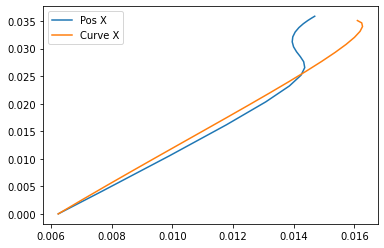

-7.047559674539302


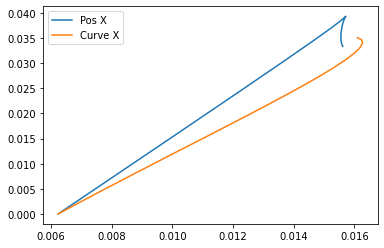

-3.86948805976245


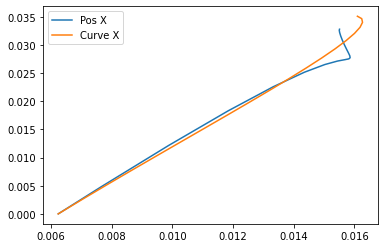

-5.379494959654673


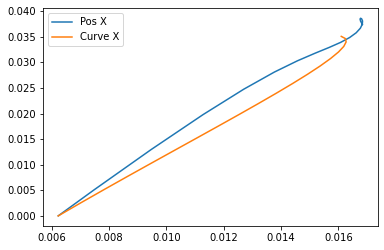

-6.798305941867319


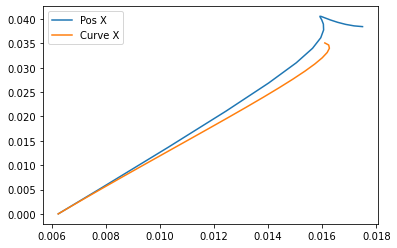

-7.0238479612171005


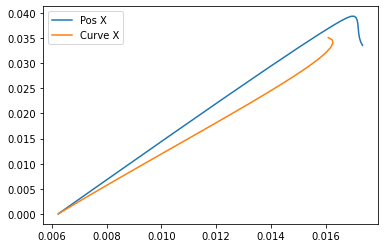

-5.851645065826952


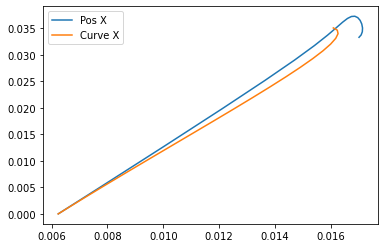

-5.924943483566686


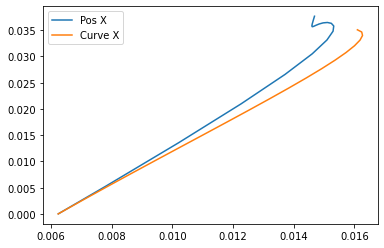

-4.587624311959583


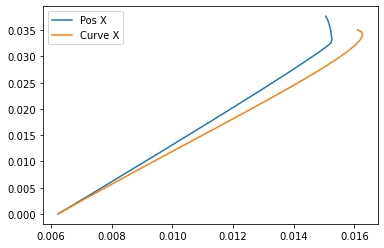

Rewards for this policy: -5.455407738071534 +- 0.9704160404447573 (1 stdev, n=100)
Solved success rate: 0.0 (0/100)

New policy param mean:
[ 0.0096296  -0.09071401 -0.15315422  0.11531153  0.05696461 -0.26252821
 -0.44412748 -0.32222221  0.07573982 -0.00839094]
New policy param var diag:
[0.42894552 0.2722501  0.45375209 0.18688427 0.3305324  0.33851096
 0.30809587 0.28491967 0.26780154 0.30588125]

-6.612440550930479


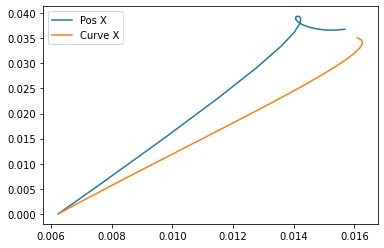

-3.0000117898404968


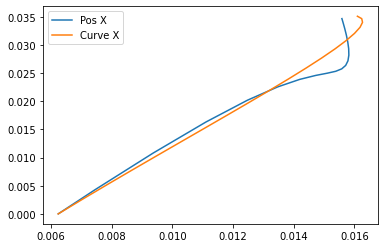

-3.122468725601983


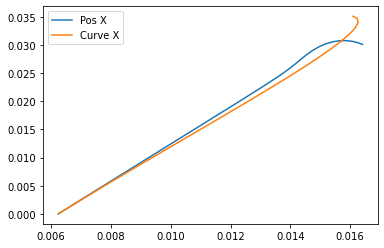

-4.499346836782291


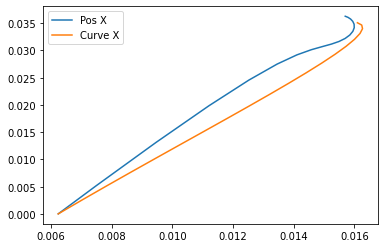

-4.87003135134829


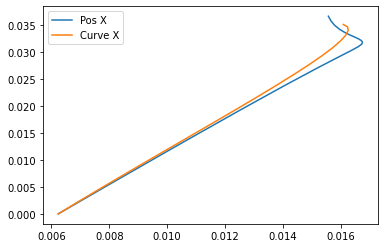

-4.176626724740113


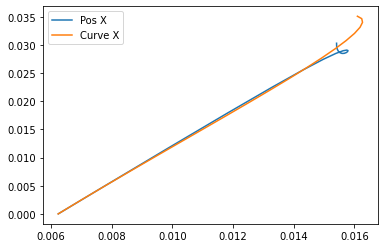

-4.48585280009742


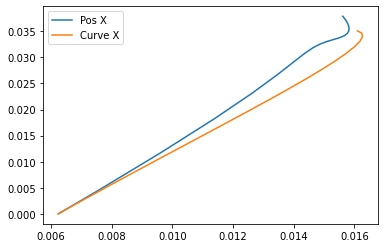

-4.668976916697373


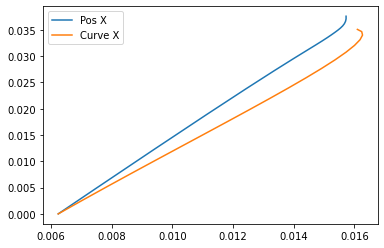

-4.654214674188048


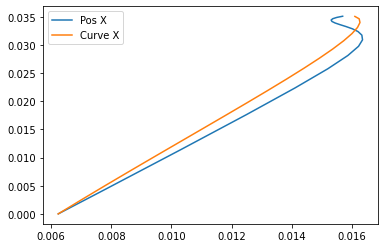

-4.41102525210943


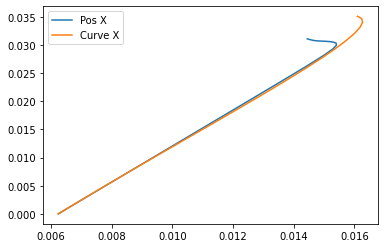

Rewards for this policy: -4.450099562233592 +- 0.9427092607362408 (1 stdev, n=10)
Solved success rate: 0.0 (0/10)

New policy param mean:
[-0.30378004 -0.3385837  -0.01902327 -0.0937942   0.01935176 -0.23999599
 -1.1284835  -0.54319881 -0.10830334 -0.11149605]
New policy param var diag:
[0.21550078 0.32867964 0.11082541 0.1008532  0.16855993 0.08891222
 0.31786483 0.25516179 0.18650018 0.30730942]

-3.8190561766569897


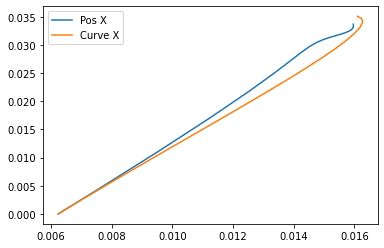

-3.1047103145562494


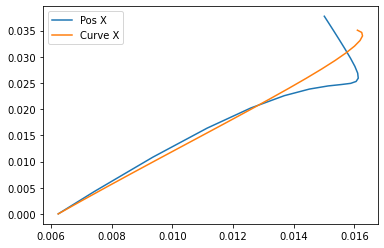

-4.0093588059665946


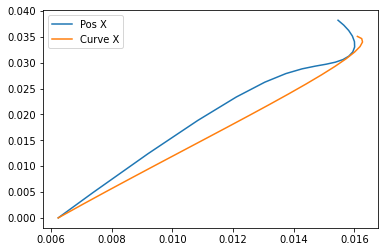

-3.4981757053055373


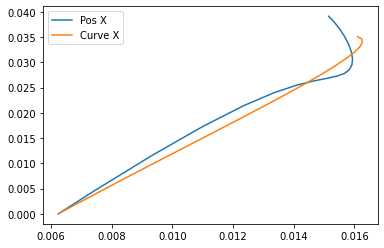

-3.483107944350123


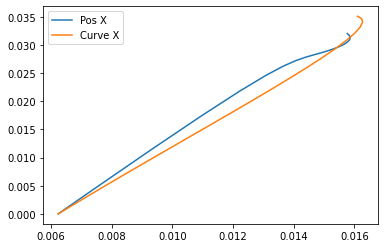

-3.9712742344109895


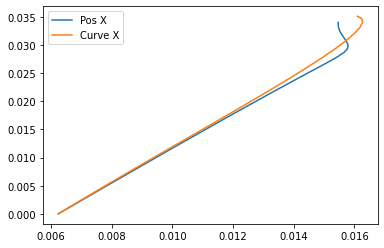

-3.9152332214506584


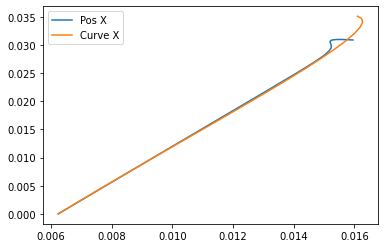

-3.960975646415674


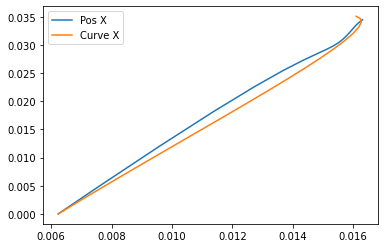

-3.7921787577207073


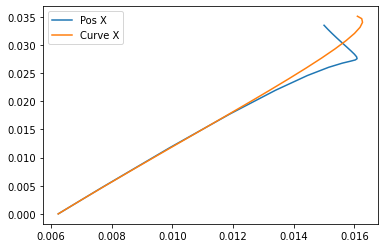

-4.338344432030268


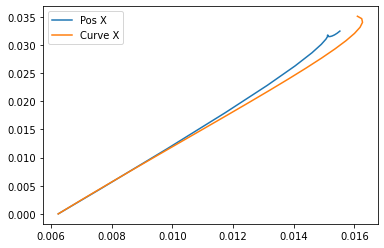

Rewards for this policy: -3.7892415238863792 +- 0.32808316669324034 (1 stdev, n=10)
Solved success rate: 0.0 (0/10)

New policy param mean:
[-0.76103858  0.03502151  0.23279539 -0.30829873 -0.41057838 -0.1514292
 -1.17109779 -1.02810324  0.41224119  0.38627161]
New policy param var diag:
[0.26965233 0.33829127 0.05019432 0.11025691 0.12817008 0.04325591
 0.07637315 0.27961687 0.35654163 0.15254125]

-3.2744434866986105


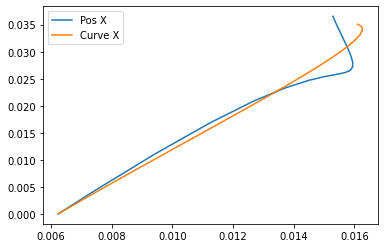

-3.792440542869329


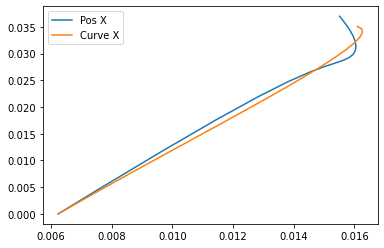

-3.4194432861308606


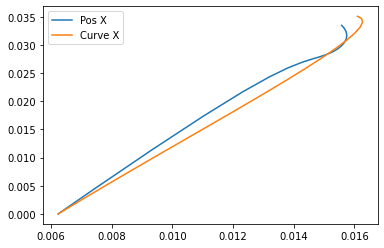

-3.8344903511948725


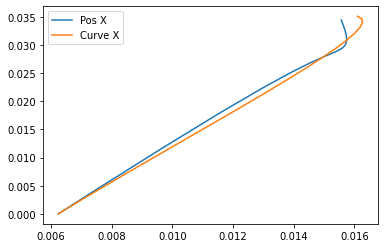

-3.694556612811238


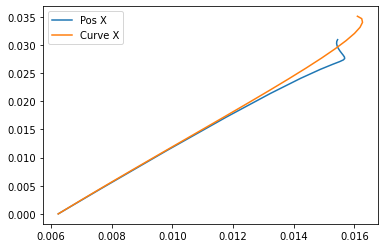

-3.392572579708142


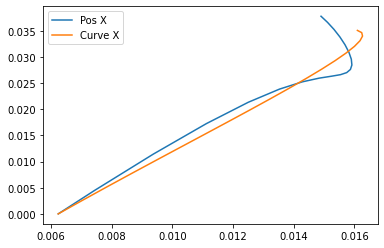

-3.2832724122044445


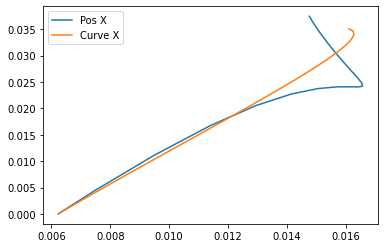

-3.1331465893027155


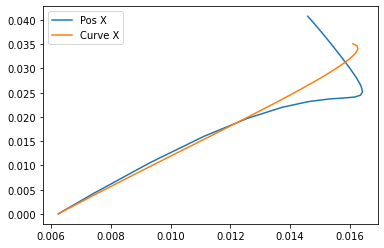

-2.96960304627686


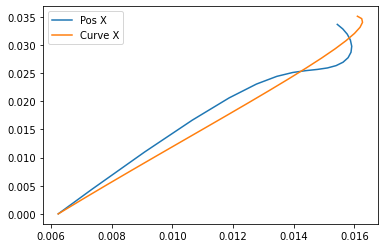

-3.0419227689070483


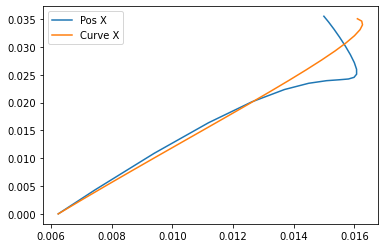

Rewards for this policy: -3.383589167610412 +- 0.2900614501545341 (1 stdev, n=10)
Solved success rate: 0.0 (0/10)

New policy param mean:
[-1.03355966  0.03741655  0.42272588 -0.38168478 -0.66807409 -0.13043996
 -1.3724084  -1.44247525  0.6220228   0.33054861]
New policy param var diag:
[0.06917384 0.4497077  0.0204428  0.15361602 0.05397572 0.01293593
 0.01731111 0.1329031  0.26116407 0.11909139]

-3.36274015340366


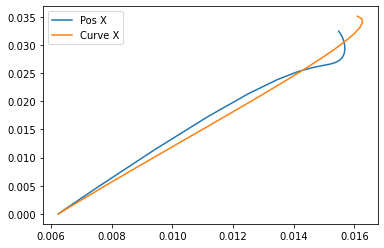

-3.1076372079397467


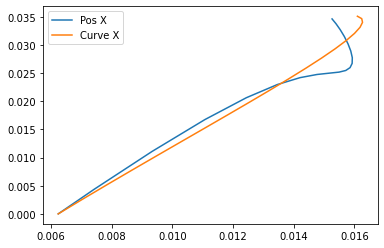

-3.1398046272744904


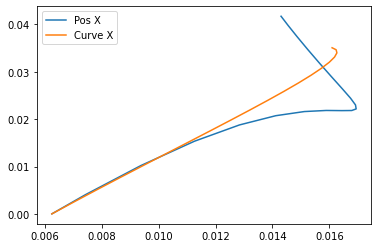

-3.4696891718699296


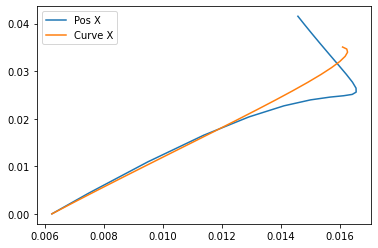

-3.2798111728729533


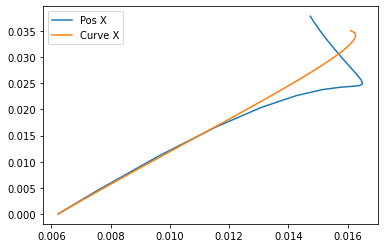

-2.9538373923953913


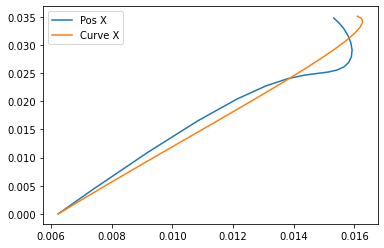

-3.1846475247075485


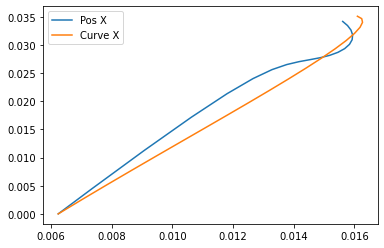

-3.0654789181762894


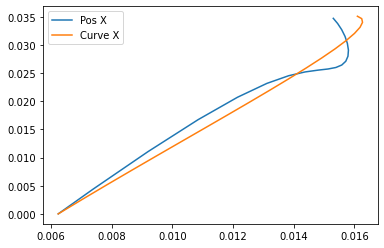

-3.2085119936089765


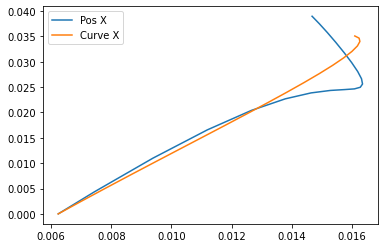

-3.1540230744915494


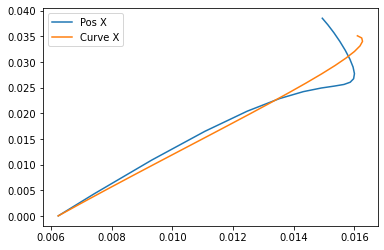

Rewards for this policy: -3.192618123674053 +- 0.14082253320851773 (1 stdev, n=10)
Solved success rate: 0.0 (0/10)

New policy param mean:
[-1.05050514 -0.07235021  0.45191726 -0.31859471 -0.70130105 -0.1187567
 -1.42019202 -1.40851353  0.61128057  0.31172131]
New policy param var diag:
[0.05957428 0.37729218 0.01474793 0.15123056 0.01263803 0.00698727
 0.01598364 0.1474597  0.27437325 0.08761073]

-2.9782541007972383


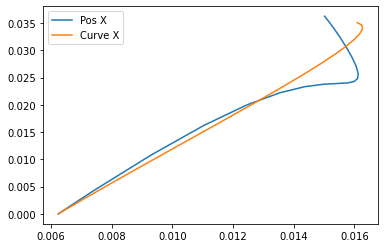

-2.8866360165150904


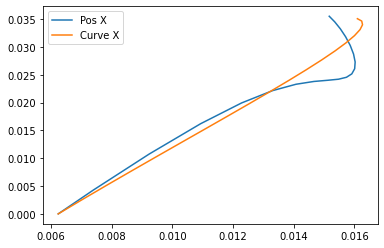

-2.983122327074703


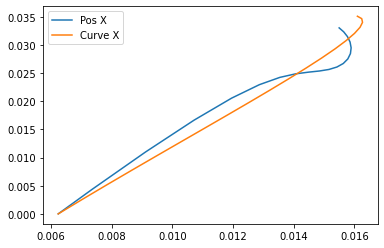

-3.056400078169877


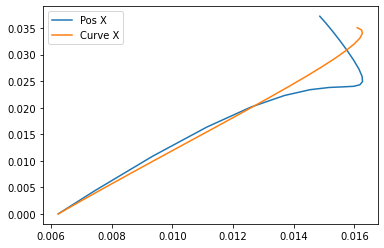

-3.0535010687762565


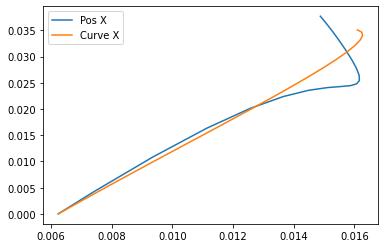

-3.0094921114301614


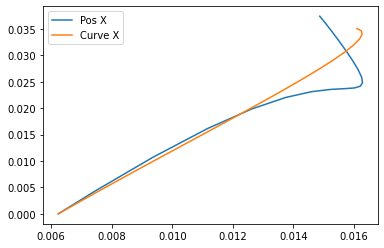

-3.325778083661859


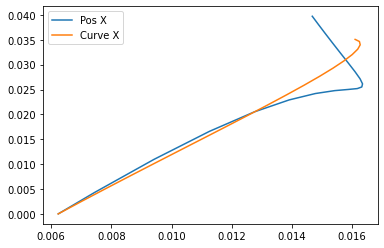

-3.0860238477854294


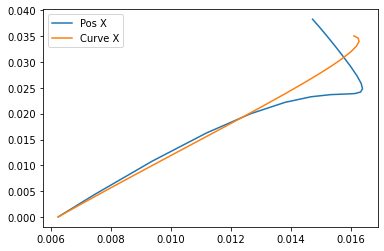

-3.089472756499006


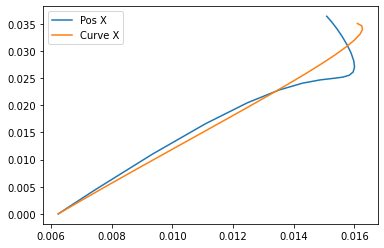

-3.0097756873679096


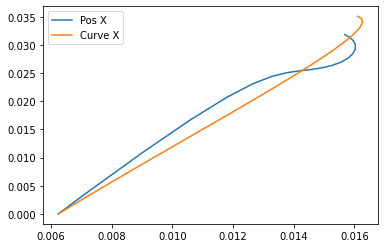

Rewards for this policy: -3.047845607807753 +- 0.10884987120826811 (1 stdev, n=10)
Solved success rate: 0.0 (0/10)

New policy param mean:
[-1.08653542 -0.03729749  0.52117183 -0.37735903 -0.66448975 -0.08490334
 -1.54226227 -1.5092376   0.65243614  0.18643373]
New policy param var diag:
[0.02026449 0.23737296 0.00255969 0.08505877 0.00331033 0.00152669
 0.00444556 0.05608641 0.12909656 0.04823852]

-2.9011438675461325


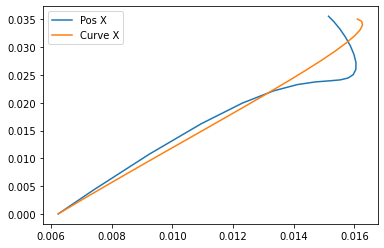

-2.950641403490296


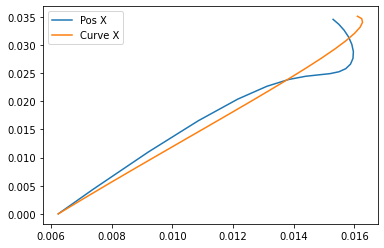

-3.0539705971298745


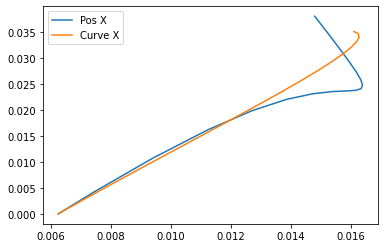

-2.893755759055774


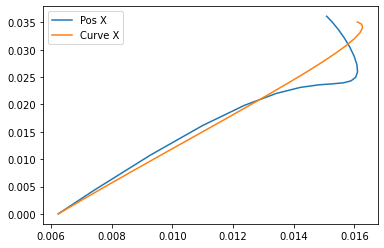

-2.9612505170265417


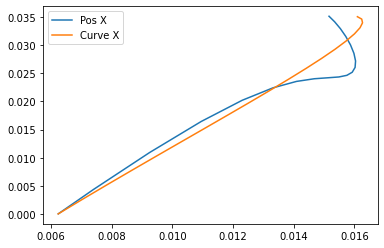

-3.058870521677213


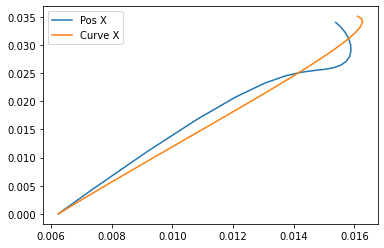

-2.9020019023385046


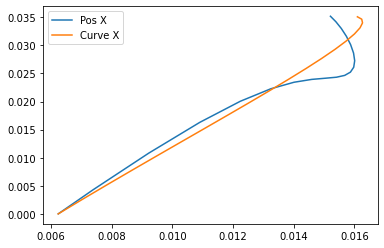

-2.9390950825288926


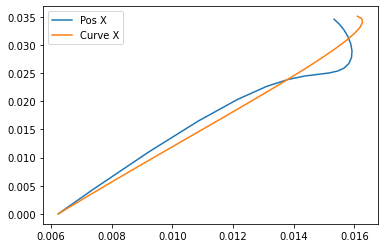

-2.920853258338451


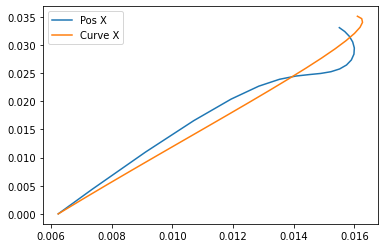

-2.9330036553525285


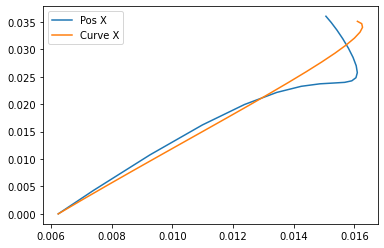

Rewards for this policy: -2.9514586564484206 +- 0.05646225598224419 (1 stdev, n=10)
Solved success rate: 0.0 (0/10)

New policy param mean:
[-1.07560954 -0.10512111  0.56710327 -0.35673361 -0.67980738 -0.06698589
 -1.59922162 -1.49813932  0.64770984  0.14167065]
New policy param var diag:
[0.00712995 0.07492487 0.00062235 0.02660523 0.00151696 0.00072907
 0.00138418 0.01824708 0.04103414 0.01144459]

-2.9422306764395216


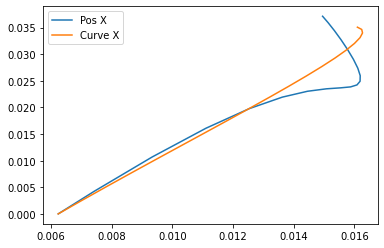

-2.8877046829829816


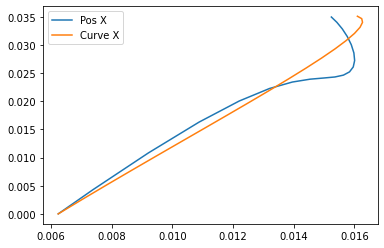

-2.8765975377595177


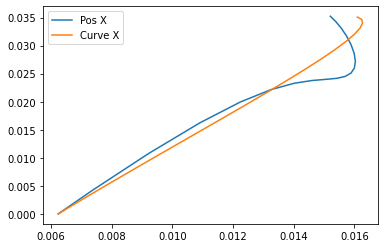

-2.927454870059288


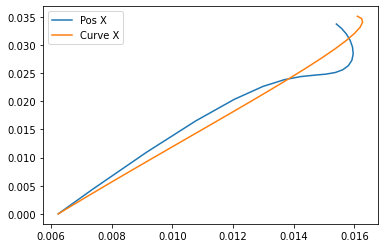

-2.8980283749664015


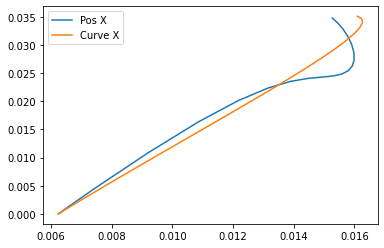

-2.9442348224262407


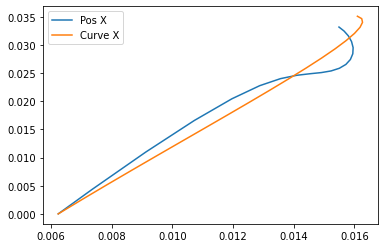

-2.8917646500751535


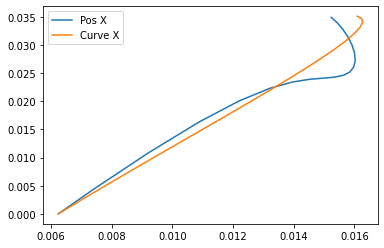

-2.903793203967063


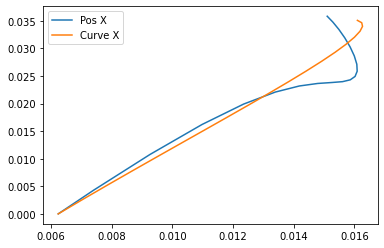

-2.9028355972575497


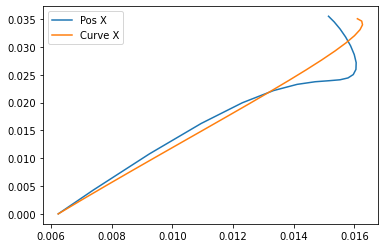

-2.8845738552565865


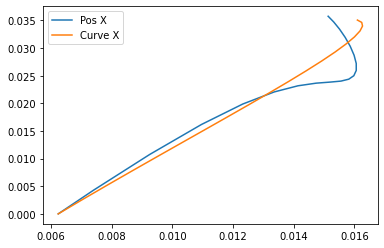

Rewards for this policy: -2.9059218271190304 +- 0.02274685115840795 (1 stdev, n=10)
Solved success rate: 0.0 (0/10)

New policy param mean:
[-1.07445887 -0.13270482  0.58448526 -0.34786797 -0.68611169 -0.06139071
 -1.62261986 -1.49677814  0.64636254  0.12228701]
New policy param var diag:
[0.00128228 0.01447239 0.00011214 0.00509685 0.00034763 0.00018242
 0.00018836 0.00306166 0.00811917 0.00222187]

-2.871089807669932


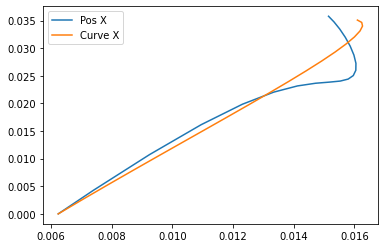

-2.8972678680488113


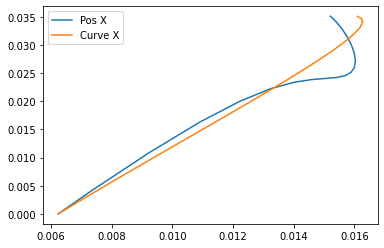

-2.8752354969840277


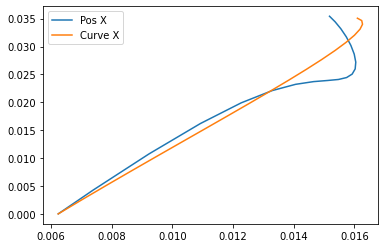

-2.880961332987745


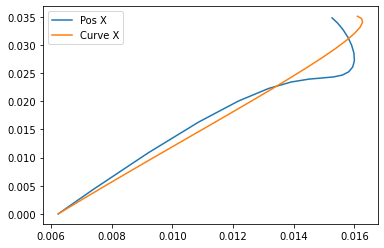

-2.8778859548829616


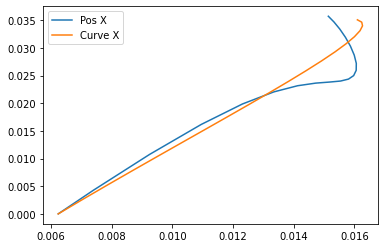

-2.8897184061461862


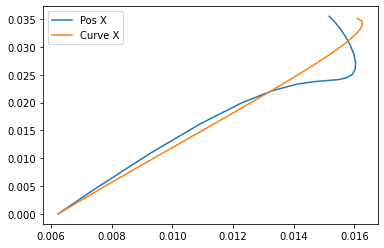

-2.8787641358591354


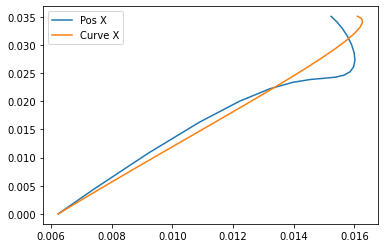

-2.8845533431088852


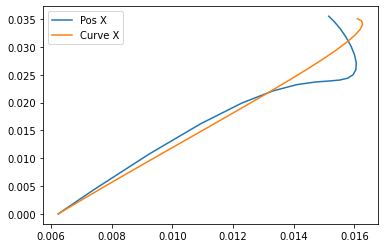

-2.8998194310430185


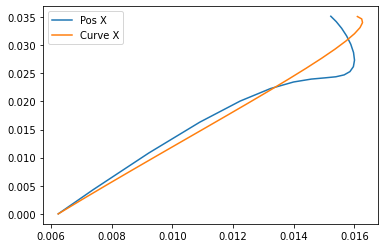

-2.893185645630689


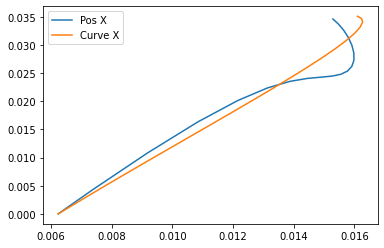

Rewards for this policy: -2.884848142236139 +- 0.00924120451555 (1 stdev, n=10)
Solved success rate: 0.0 (0/10)

New policy param mean:
[-1.09383195 -0.07595714  0.58122383 -0.37956111 -0.67444324 -0.07443789
 -1.62886    -1.51936123  0.69554291  0.14779794]
New policy param var diag:
[7.31032096e-04 8.52431357e-03 6.75834677e-05 2.88655568e-03
 2.16627695e-04 1.63188197e-04 8.82951288e-05 1.49256564e-03
 5.15063266e-03 1.55481361e-03]

-2.873775841803272


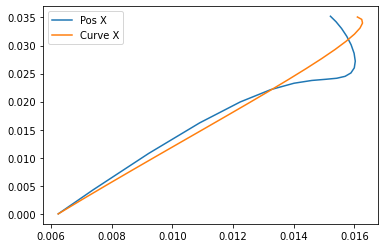

-2.8759940853138177


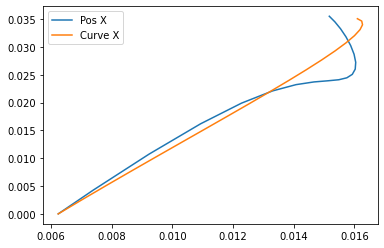

-2.8794701245741514


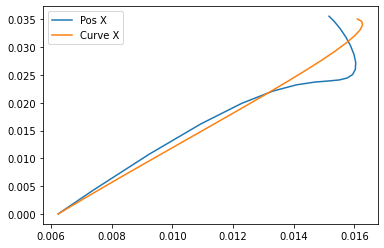

-2.8780618956197364


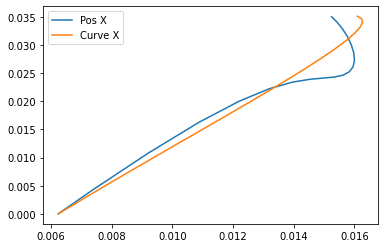

-2.865408135403717


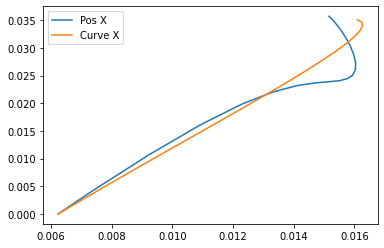

-2.8747880360181397


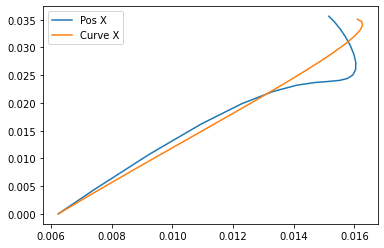

-2.88157208074708


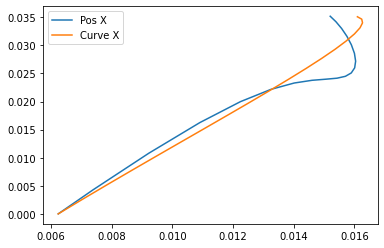

-2.8833556917108516


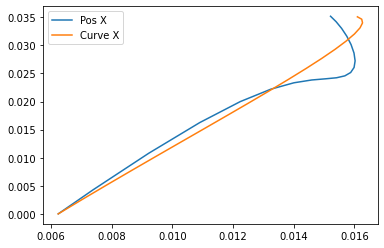

-2.873118393416861


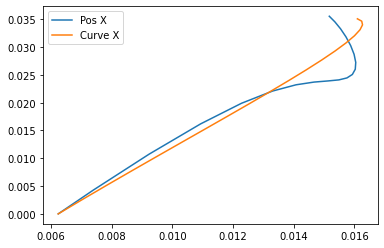

-2.8742069680986275


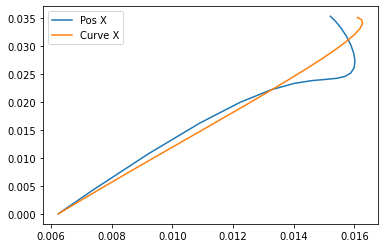

Rewards for this policy: -2.8759751252706254 +- 0.004812102054908059 (1 stdev, n=10)
Solved success rate: 0.0 (0/10)

New policy param mean:
[-1.09885402 -0.06692507  0.57340579 -0.38180544 -0.66660381 -0.08399468
 -1.62558621 -1.51932978  0.70440948  0.15426938]
New policy param var diag:
[2.59091328e-04 2.97049004e-03 5.82761369e-05 9.46573972e-04
 1.27195417e-04 1.26290483e-04 4.36988599e-05 3.97564078e-04
 1.93328795e-03 6.25296770e-04]

-2.867683844756944


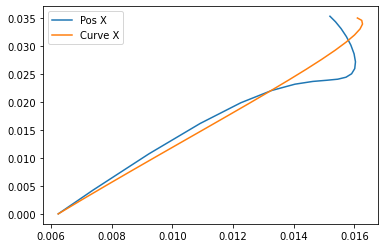

-2.8712962907408843


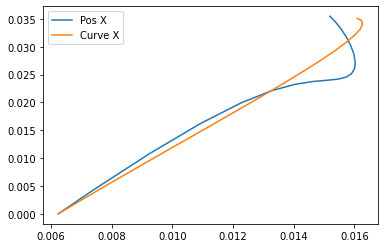

-2.869068171560545


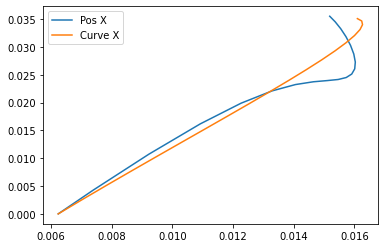

-2.8694405600376407


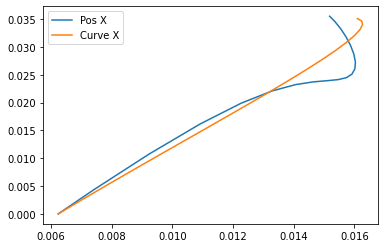

-2.8753436970239172


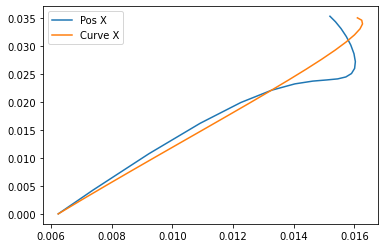

-2.87253457564263


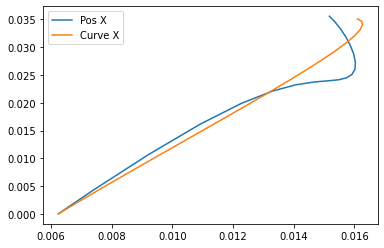

-2.8820708987041033


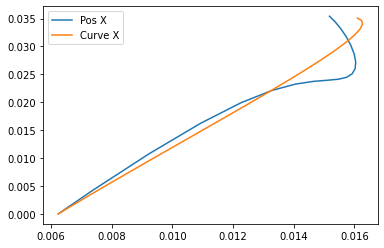

-2.8733166237508


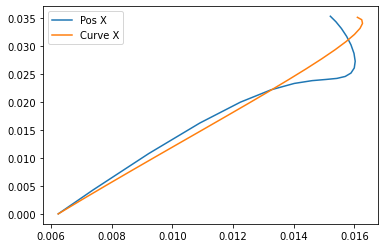

-2.8726929913926513


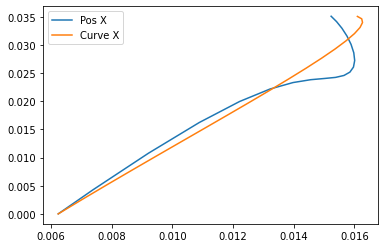

-2.881819342209884


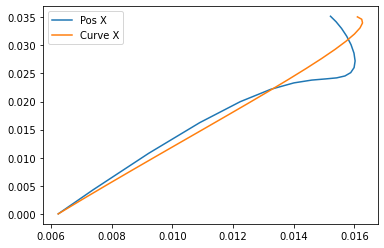

Rewards for this policy: -2.873526699582 +- 0.004716830883189296 (1 stdev, n=10)
Solved success rate: 0.0 (0/10)

New policy param mean:
[-1.09138644 -0.09629347  0.57340164 -0.36472829 -0.6698558  -0.08208043
 -1.62414754 -1.50789546  0.68269258  0.14133612]
New policy param var diag:
[5.83383732e-05 7.34801372e-04 3.93721989e-05 2.26986029e-04
 3.52113946e-05 3.36590626e-05 4.16995685e-05 9.71831320e-05
 4.20652885e-04 1.64539831e-04]

-2.867711586184295


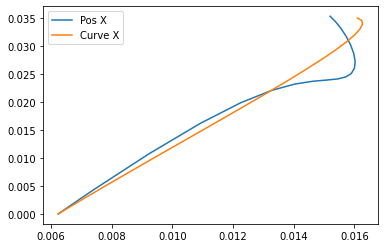

-2.8665924584234013


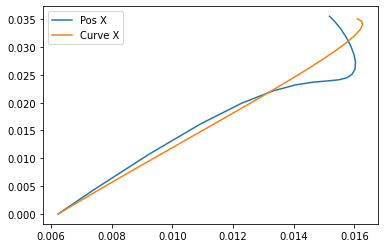

-2.8705104773323016


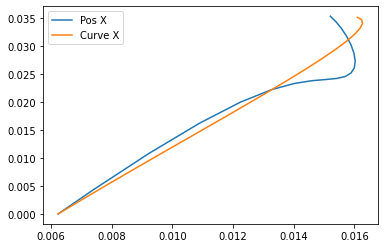

-2.8653297963202853


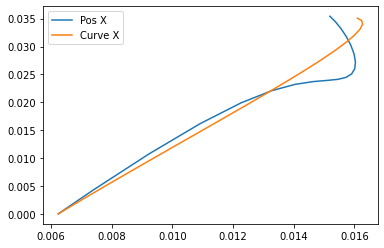

-2.867891434125253


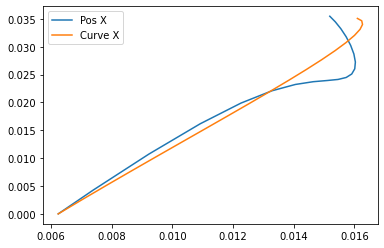

-2.875202159421638


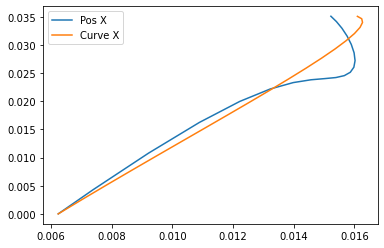

-2.8679933667864166

KeyboardInterrupt: 

In [64]:
""" Train a REPS model to match the GT Trajecotry """
from rl_util.identity_policy import IdentityLowLevelPolicy
from rl_util import env_interaction

num_bfs = 5
policy = IdentityLowLevelPolicy(num_bfs*2)
mu = np.zeros(num_bfs*2)
sigma = 0.35

max_num_reps_attempts = 10
max_reps_param_updates = 20

num_policy_rollouts_before_reps_update = 10 * policy.num_params()
env_convergence_criteria = {"env_solved": 0.9}

# Set default Mean and Variance for policy
policy_params_mean_init = np.zeros(policy.num_params()) + mu
policy_params_var_init = np.eye(policy.num_params()) * sigma

curve = pickle.load(open("../data/trajs/curve.pkl",'rb'))
start = (curve[0][0],curve[1][0])
goal = (curve[0][-1],curve[1][-1])
env = Env(start, goal, curve, num_bfs)

reps_converged, low_level_policy_params_mean, \
    low_level_policy_params_var, solve_env_info = \
            env_interaction.solve_env_using_reps(env,
                                policy, policy_params_mean_init,
                                policy_params_var_init, num_policy_rollouts_before_reps_update,
                                max_reps_param_updates, env_convergence_criteria,
                                max_num_reps_attempts=max_num_reps_attempts, debug_info=True, verbose=True,)

reps_policy = {'reps_converged': reps_converged,
            'low_level_policy_params_mean': low_level_policy_params_mean,
            'low_level_policy_params_var': low_level_policy_params_var,
            'solve_env_info': solve_env_info}

In [52]:
reps_policy

{'reps_converged': True,
 'low_level_policy_params_mean': array([-1.73979043, -4.59386912,  3.6955001 , -2.61572121, -1.36102063,
        -1.29916282, -2.00360605,  2.20340181, -2.77801562, -2.63312865,
         0.69258003, -4.4915574 , -5.97879722, -1.32595096, -1.18875359,
         0.19733752,  1.92474094, -1.71732331,  0.27895054,  0.08410491]),
 'low_level_policy_params_var': array([[ 9.01352048e-03, -1.08469465e-03,  2.50456743e-04,
         -6.50883063e-03,  6.95146245e-03, -9.69486875e-03,
          1.45051843e-02, -1.05544432e-02,  9.32759036e-03,
          5.63694928e-03,  8.01205542e-03,  1.78281109e-03,
          1.32083522e-03, -1.34123558e-04,  5.13708679e-03,
          7.01116112e-03, -2.32405200e-03, -2.74710816e-03,
          2.88985507e-03,  6.04494432e-03],
        [-1.08469465e-03,  1.45167351e-03,  3.41093510e-04,
          2.12081915e-04, -8.19962982e-04,  2.06973637e-03,
         -3.65774413e-03,  4.06185836e-03, -5.12667974e-03,
         -7.92326264e-04, -8.00344

Temp Delete Later: 

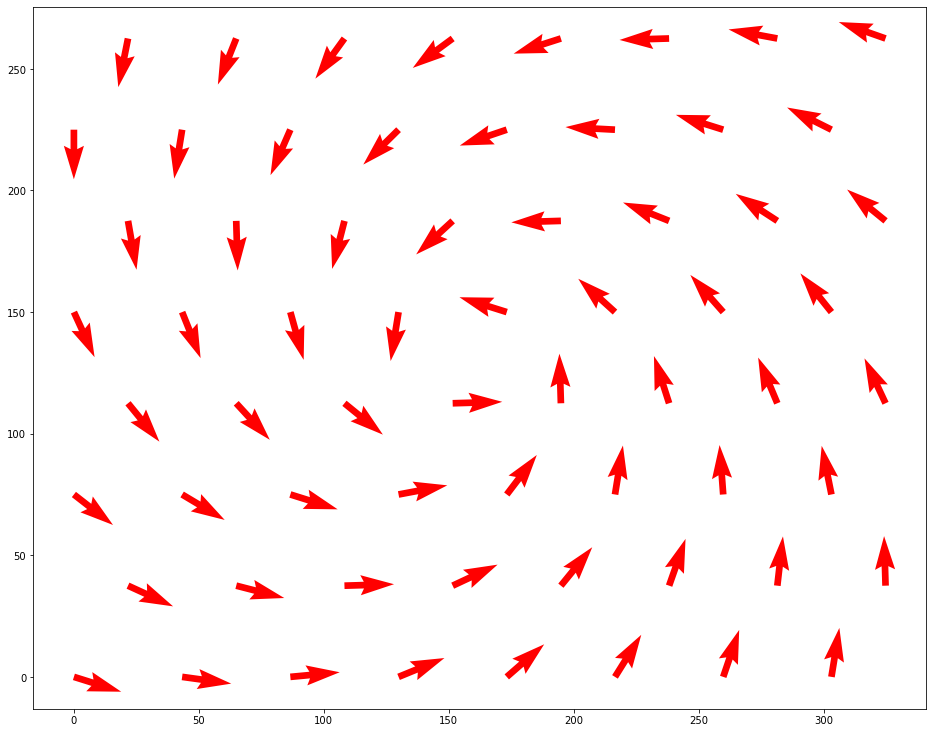

In [56]:
def rotate(vector, angle, plot=False):
    # Rotation from Delta Array axis to cartesian axis = 30 degrees. 
    rot_matrix = np.array([[np.cos(angle), -np.sin(angle)],[np.sin(angle), np.cos(angle)]])
#     print(vector, rot_matrix)
    vector = vector@rot_matrix
    return vector

robot_positions = np.zeros((8,8,2))
delta_array = np.zeros((8,8))
rot_30 = 45

x1 = 303.107
x2 = 324.75
y = 262.5

plt.figure(figsize=(16, 16*262.2/324.75))
for i in range(8):
    for j in range(8):
        if j%2==0:
#             print(np.array([-robot_positions[i,j][0] + 303.107/2, -robot_positions[i,j][1] + 262.5/2]))
            robot_positions[i,j] = (i*43.301, j*37.5)
            _ = plt.quiver(robot_positions[i,j][0],robot_positions[i,j][1],
                       *rotate(vector=np.array([-robot_positions[i,j][0] + x1/2, -robot_positions[i,j][1] + y/2]), angle=rot_30), color='r')
        else:
#             print(np.array(-robot_positions[i,j][0] + 303.107/2, -robot_positions[i,j][1] + 262.5/2))
            robot_positions[i,j] = (21.65 + i*43.301, j*37.5)
            _ = plt.quiver(robot_positions[i,j][0],robot_positions[i,j][1],
                       *rotate(vector=np.array([-robot_positions[i,j][0] + x2/2, -robot_positions[i,j][1] + y/2]), angle=rot_30), color='r')

plt.savefig("rot_vectors_transparent.png", transparent=True)
plt.show()

In [30]:
robot_positions

array([[[  0.   ,   0.   ],
        [ 21.65 ,  37.5  ],
        [  0.   ,  75.   ],
        [ 21.65 , 112.5  ],
        [  0.   , 150.   ],
        [ 21.65 , 187.5  ],
        [  0.   , 225.   ],
        [ 21.65 , 262.5  ]],

       [[ 43.301,   0.   ],
        [ 64.951,  37.5  ],
        [ 43.301,  75.   ],
        [ 64.951, 112.5  ],
        [ 43.301, 150.   ],
        [ 64.951, 187.5  ],
        [ 43.301, 225.   ],
        [ 64.951, 262.5  ]],

       [[ 86.602,   0.   ],
        [108.252,  37.5  ],
        [ 86.602,  75.   ],
        [108.252, 112.5  ],
        [ 86.602, 150.   ],
        [108.252, 187.5  ],
        [ 86.602, 225.   ],
        [108.252, 262.5  ]],

       [[129.903,   0.   ],
        [151.553,  37.5  ],
        [129.903,  75.   ],
        [151.553, 112.5  ],
        [129.903, 150.   ],
        [151.553, 187.5  ],
        [129.903, 225.   ],
        [151.553, 262.5  ]],

       [[173.204,   0.   ],
        [194.854,  37.5  ],
        [173.204,  75.   ],
        [194